## Importing the modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model, Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation, Dense, Dropout, Input

Using TensorFlow backend.


The code blocks mentioned below step 2 and step 3 define two different neural networks. The only major difference between generator and discriminator network are inputs and outputs

> The Generator networks takes random noise as input and tries to recreate the images from the training set.

> The discriminator is binary classifier tries to distinguish the images generated by the generator network from the actual train images.

## Building a simple Generator Network

In [2]:
def build_generator():
    #initializing the neural network
    generator= Sequential()
    #adding an input layer to the network
    generator.add(Dense(units=256, input_dim=100))
    #activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))
    #applying batch Normalization
    generator.add(Dense(units=512))
    #adding the third layer
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    #the output layer with 784(28x28) nodes
    generator.add(Dense(units=784, activation='tanh'))
    #compiling the generator network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    return generator

## Building a Simple Discriminator Network

In [3]:
def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim=784))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    
    return discriminator


## Building a GAN Networks

This code creates a GAN by stacking the generator and discriminator networks

The trainable parameter of the discriminator network when set to false freezes the weights in the discriminator network while the generator network is trained. This prevents the discriminator network from being updated while the generator generates new image from noise.

The input shape to the GAN network is the shape of the noise. The noise is fed to the generator and its output is fed to the discriminator which classifies the image as original or generated.

In [4]:
#Stacking The Generator And Discriminator Networks To Form A GAN

def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 100 (Noise shape)
    inp = Input(shape=(100,))
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam')
    
    return gan

## Plotting the generated images

In [15]:
#Method to plot the images
def plot_images(epoch, generator, dim = (10,10), figsize=(15,15)):
    #Generate a normally distributed noise of shape(100x100)
    noise= np.random.normal(loc=0, scale=1, size=[100, 100]) 
    #Generate an image for the input noise
    generated_images = generator.predict(noise)
    #Reshape the generated image 
    generated_images = generated_images.reshape(100,28,28)
    
    #Plot the image 
    plt.figure(figsize=figsize)
   
    #Plot for each pixel
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i],cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

## Method for training

In [16]:
#Traing method with training set, default epoch and default batch_size as arguments.

def train(X_train, epochs=5, batch_size=128):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    
    # Training the model for specified epochs
    
    for epoch in range(1,epochs+1 ):
        print("###### @ Epoch ", epoch)
        
        #tqdm module helps to generate a status bar for training 
        for _ in tqdm(range(batch_size)):
          
            #Random noise with size batch_sizex100
            noise= np.random.normal(0,1, [batch_size, 100])
            
            #Generating images from noise
            generated_images = generator.predict(noise)
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images a sreal images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        #Plotting the images for every 10 epochs
        if epoch == 1 or epoch % 10 == 0:
          plot_images(epoch,generator,dim = (10,10) , figsize=(15,15))

## Loading and Processing MNIST Data

In [17]:
#Unpacking the training data from mnist data dataset
(X_train, _), (_, _) = mnist.load_data()

#Converting to float type and normalizing the data
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# convert shape of X_train from (60000, 28, 28) to (60000, 784) - 784 columns per row
X_train = X_train.reshape(60000, 784)

## Training the GAN

  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  1


  2%|▏         | 2/128 [00:00<00:11, 11.12it/s]

###### @ Epoch  2


  1%|          | 1/128 [00:00<00:13,  9.34it/s]

###### @ Epoch  3


  1%|          | 1/128 [00:00<00:20,  6.28it/s]

###### @ Epoch  4


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  5


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


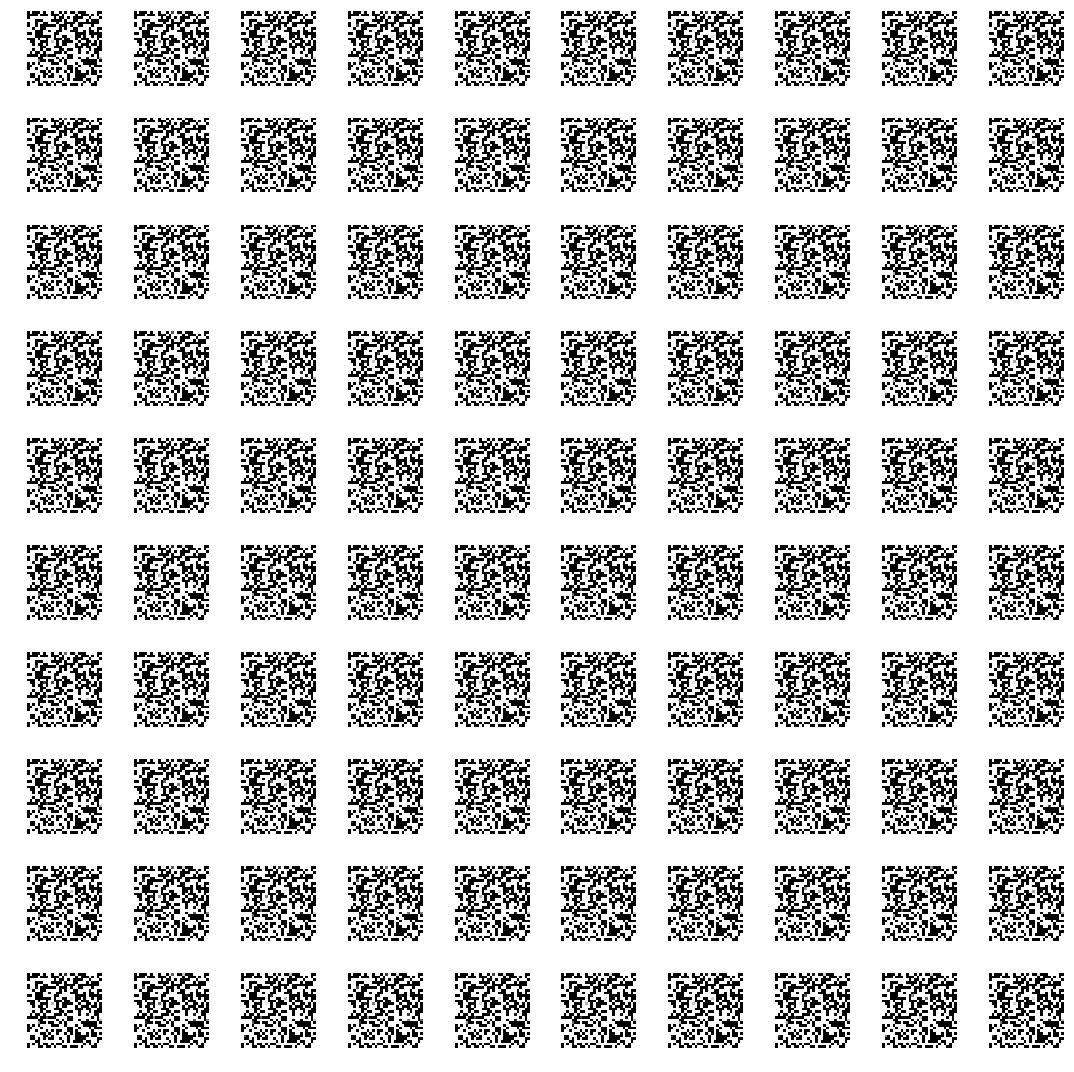

In [18]:
train(X_train,epochs = 5, batch_size = 128)